In [56]:
import numpy as np
import pandas as pd
import uuid

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [192]:
class ptype:
    """basic particle type, with name and physical properties
    it also has a list of unimolecular reactions A -> products
    """
    def __init__(self,diffusion,name,geometry):
        self.diffusion=diffusion
        self.name=name
        self.unimolecular_reactions = []
        self.unimolecular_probs = []
        self.geometry= geometry
        
    def add_reaction(self,reaction):
        """adds a unimolecular_reaction to the list for this particle type
        and updates the probabilities function"""
        (self.unimolecular_reactions).append(reaction)
        rates = np.array([rea.rate for rea in self.unimolecular_reactions])
        self.unimolecular_probs = rates
        
    def choose_reaction(self,dt):
        """chooses one reaction (or none) for a given time step
        that reaction can then be effected on a particle with effect_reaction
        """
        if len(self.unimolecular_probs)==0:
            return None
        else:
            rates = self.unimolecular_probs
            probs = (rates/rates.sum())*(1 - np.exp( - dt* rates.sum()))
            #print("Cumulative probs: ",np.cumsum(probs))
            alpha=np.random.uniform(size=1)
            conf = np.cumsum(probs)>alpha
            if any(conf):
                ii = np.argmax(conf)
                print("Chosen rection %s" % self.unimolecular_reactions[ii].name)
                return self.unimolecular_reactions[ii]
            else:
                return None
        

class geometry(object):
    """a basic basic geometry specification
    ideally it would include boundary conditions, dimensionality
    external potentials, etc. 
    It's used to evolve the dynamics of particles, 
    so each particle type is attached to a geometry object at construction
    """
    def __init__(self, size, dim=2):
        self.dim=dim
        self.size=size
        self.bc='pbc'
        
        
        
class particle:
    """particle instance, it has an id, position, age, types, etc."""
    def __init__(self, ptype, pos, age = 0, id = None ):
        if id==None:
            self.id = uuid.uuid4()
        else:
            self.id = id
        self.ptype = ptype
        self.age = age
        self.pos = pos
        
    def step(self,dt):
        pos1 = self.pos + np.sqrt(2*self.ptype.diffusion*dt)*np.random.normal(0, 1, 2)
        if(self.ptype.geometry.bc == 'pbc'):
            box = self.ptype.geometry.size
            pos1=pos1 - np.floor(pos1/box) * box
        #print("type %s, age %d"% (self.ptype.name, self.age))
        pnew = particle(self.ptype, pos1,
                        age = self.age + 1, id = self.id)
        return pnew

        
class traj:
    """a traj is a list of lists of particles"""
    
    def __init__(self, particles):
        self.ptraj = []
        self.nframes = 0
        (self.ptraj).append(particles)
        
    def step(self,dt):
        newvals=[]
        for pa in (self.ptraj)[self.nframes]:
            pa1 = pa.step(dt)
            newvals.append(pa1)
        (self.ptraj).append(newvals)
        self.nframes = (self.nframes)+1

    def react_unimolecular(self, dt):
        ###### unimolecular reactions would be defined 
        ###### on unm_inducts to mimick other orders
        ###### then here we can pass the set of unim_inducts 
        """loops over particles and reacts them with their unimolecular reactions
         unimolecular reactions are associated to the incoming pair
        """
        newvals=[]
        for pa in (self.ptraj)[self.nframes]:
            react = pa.ptype.choose_reaction(dt)
            if(not react==None):
                pa1 = react.effect_reaction(pa)
                if not pa1==None:
                    for pa11 in pa1:
                        newvals.append(pa11)
            else:
                newvals.append(pa)
        
        (self.ptraj)[self.nframes] = newvals
        
    def react_bimolecular(self, dt, bim_inducts):
        """ bimolecular reactions        
        """
        frame = (self.ptraj)[self.nframes]
        print("reacting frame %d" % self.nframes)
        #loop over inducts, get instances, choose reaction, effect reaction
        # remember to add the particles that are not in any instance
        for induct in bim_inducts:
            print("induct name: %s"%induct.name)
            induct_instances = induct.get_ec(frame)
            if len(induct_instances)>0:
                print(induct_instances)
            for EC_instance in induct_instances:
                react = induct.choose_reaction(dt)
                if(not react==None):
                    pa1 = react.effect_reaction(EC_instance)
                    ## remove incoming particles from frame
                    for part in EC_instance:
                        #### EC_instance is a list of two (index,particle)
                        print("removing part %d" % part[0])
                        del(frame[part[0]])
                    ## add educts
                    if not pa1==None:
                        for pa11 in pa1:
                            frame.append(pa11)
                            
            

In [223]:
#col_dict = {'type 1':'red','type 1b':'blue','type 2':'orange'}
#col_dict = {'type 1':1,'type 1b':2,'type 2':3}
#size_dict = {'type 1':10,'type 1b':20,'type 2':30}

### http://stackoverflow.com/questions/9401658/how-to-animate-a-scatter-plot

def plt_traj2(traj, col_dict, size_dict):
    """plots a trajectory"""
    ptraj = (traj.ptraj)
    fig = plt.figure()
    ax = plt.axes(xlim=(0, 20), ylim=(0, 20))
    scat = ax.scatter([],[], c=[], marker='o', lw=1, vmin = 0, vmax=10)
        
    def init():
        scat.set_offsets(np.hstack(([], [])))
        return scat,
        
    def animate(i):
        x = [p.pos[0] for p in ptraj[i]]
        y = [p.pos[1] for p in ptraj[i]]
        cols = [1.*col_dict[p.ptype.name] for p in ptraj[i]]
        sizs = [size_dict[p.ptype.name] for p in ptraj[i]]
        scat.set_offsets(np.vstack((x, y)).T)
        scat._sizes = np.array(sizs)*5
        scat.set_array(np.array(cols))
        return scat,

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=traj.nframes, interval=20, blit=True)
    return anim

 

In [4]:
def reshape(traj):
    """converts a frame-based trajectory into a id-based data-frame
    for lifetimes and concentrations
    
    """
    pp=[]
    for i,frame in enumerate(traj.ptraj):
        for part in frame:
            pp.append([part.id,part.age,part.pos[0],part.pos[1],i,part.ptype.name])
    gg = pd.DataFrame(pp,columns=['ID','age','x','y','frame','type_name'])
    return gg


In [5]:
class reaction:
    def __init__(self,name,rate):
        self.rate = rate
        self.name = name
        #print(self)

### ============== UNI_MOLECULAR REACTIONS ===============================
        
class decay_reaction(reaction):
    """ unimolecular decay with given rate"""
    def __init__(self, name, rate):
        super(decay_reaction,self).__init__(name,rate)
        
    def effect_reaction(self,particle_in):
        return None
    
class convert_reaction(reaction):
    """ unimolecular conversion with given rate to given type """
    def __init__(self,  name, rate , outtype):
        self.outtype=outtype
        super(convert_reaction,self).__init__( name, rate)
        
    def effect_reaction(self,particle_in):
        ## return a singleton list for consistence with other reactions
        return [particle(self.outtype, particle_in.pos )]

class fission_reaction(reaction):
    """ unimolecular fission with given rate to given type """
    def __init__(self,  name, rate, outtype1, outtype2):
        self.outtype1=outtype1
        self.outtype2=outtype2
        super(fission_reaction,self).__init__( name, rate)
        
    def effect_reaction(self,particle_in):
        pos = particle_in.pos
        return [particle(self.outtype1, pos) ,particle(self.outtype2, pos ) ]  

In [152]:
#### abstract types of EC
### zz=bim_encunter_complex("bim1",p1,p3,.9)
#### add reactions to the EC_type
### r1 = annihilation_reaction("anni1", 1.1)
### r2 = ...
### zz.add_reaction(r1)
### zz.add_reaction(r2)

#### don't confuse with realizations of ECs in the simulation that can be obtained with
### zz.get_ec(t.ptraj[100])

### for a timestep, cycle over ectypes, get all ECs, 
### choose reaction for each ec, apply reaction

class encunter_complex_type:
    def __init__(self, name):
        self.name=name
        
class bim_encunter_complex(encunter_complex_type):
    
    def __init__(self, name, typ1,typ2, dist):
        self.type1 = typ1
        self.type2 = typ2
        self.dist= dist
        self.bim_reactions = []
        self.bim_probs = []
        super(bim_encunter_complex,self).__init__(name)
        
    def add_reaction(self,reaction):
        """adds a unimolecular_reaction to the list for this particle type
        and updates the probabilities function"""
        
        ## should check if reaction type is ok ...
        (self.bim_reactions).append(reaction)
        rates = np.array([rea.rate for rea in self.bim_reactions])
        self.bim_probs = rates

    def choose_reaction(self,dt):
        """chooses one reaction (or none) for a given time step
        that reaction can then be effected on a particle with effect_reaction
        """
        if len(self.bim_reactions)==0:
            return None
        else:
            rates = self.bim_probs
            probs = (rates/rates.sum())*(1 - np.exp( - dt* rates.sum()))
            #print("Cumulative probs: ",np.cumsum(probs))
            alpha=np.random.uniform(size=1)
            conf = np.cumsum(probs)>alpha
            if any(conf):
                ii = np.argmax(conf)
                print("Chosen rection %s" % self.bim_reactions[ii].name)
                return self.bim_reactions[ii]
            else:
                return None
            
    def get_ec(self,particles_):
        """returns a list of instances of hte ECtype
        each of these are a vector of (two) (index, particle)
        bimolecular reactions effect_reaction functions take one of the instances
        and modify it
        
        the bimol react function of the traj loops over the instances,
        picks a reaction and reacts it
        """
        p1 = [i for i,p in enumerate(particles_) if p.ptype==self.type1]
        p2 = [i for i,p in enumerate(particles_) if p.ptype==self.type2]
        ec=[]
        #print(p1)
        #print(p2)
        for q1 in p1:
            for q2 in p2:
                if not q1 == q2:
                    vec1= particles_[q1].pos - particles_[q2].pos
                    #print(vec1)
                    dist1= np.sqrt((vec1 * vec1).sum())
                    if dist1 < self.dist:
                        ec.append([(q1,particles_[q1]),(q2,particles_[q2])])
        return ec

In [153]:
class annihilation_reaction(reaction):
    """ annihilation reaction"""
    def __init__(self, name, rate):
        super(annihilation_reaction,self).__init__(name,rate)
        
    def effect_reaction(self,encunter_complex_in):
        return None

class fusion_reaction(reaction):
    """ fusion reaction"""
    def __init__(self, name, rate, outtpye):
        self.outtype = outtpye
        super(fusion_reaction,self).__init__(name,rate)
        
    def effect_reaction(self,encunter_complex_in):
        pos = None ## get particle pos in encounter complex in and average
        poss = [part[1].pos for part in encunter_complex_in]
        print([part[0] for part in encunter_complex_in])    
        return [particle(self.outtype, poss[0])]  

### Run 

##### init

In [185]:
### create particle types and their unimolecular reactions
#membrane = geometry(dim=2,size=10)
#
#p1 = ptype(1.0e-2,"slow",geometry=membrane)
#p2 = ptype(1.0e-1,"fast",geometry=membrane)
#p3 = ptype(1.0e-2,"slow2",geometry=membrane)

## fast -> 0, slow -> slow2
#p2.add_reaction( decay_reaction("dec1",.5) )
#p1.add_reaction( convert_reaction("con1",.1, p3) )



### define bimolecular reactions
#zz=bim_encunter_complex("bim1",p1,p2,.9)
#r1 = annihilation_reaction("ANN", rate=3.1)
#zz.add_reaction(r1)
#r2 = fusion_reaction("fusion1", rate=0.1, outtpye=p3)
#zz.add_reaction(r2)


#bim_inducts = [zz]


#init_pos = [
#    particle(p1, np.array([0,i]),age=0) for i in range(10)] + [
#    particle(p2, np.array([i,0]),age=0) for i in range(10)] 
#t = traj(init_pos)

In [187]:
## create particle types and their unimolecular reactions
#membrane = geometry(dim=2,size=10)
#p1 = ptype(1.0e-2,"mono",membrane)
#p2 = ptype(1.0e-1,"dimer",membrane)

## fast -> 0, slow -> slow2
## p1.add_reaction( convert_reaction("con1",.1, p3) )


### define bimolecular reactions
#zz=bim_encunter_complex("bim1",p1,p1,.9)
#r2 = fusion_reaction("fusion1", rate=2, outtpye=p2)
#zz.add_reaction(r2)


#bim_inducts = [zz]
##

#init_pos = [
#    particle(p1, np.array([0,i]),age=0) for i in range(10)] + [
#    particle(p1, np.array([i,0]),age=0) for i in range(10)] 
#t = traj(init_pos)

In [216]:
## create particle types and their unimolecular reactions
membrane = geometry(dim=2,size=20)

p1 = ptype(1.0e-2,"mono",membrane)
p2 = ptype(1.0e-1,"dimer",membrane)
zz=bim_encunter_complex("bim1",p1,p1,1.1)
r2 = fusion_reaction("fusion1", rate=4, outtpye=p2)
zz.add_reaction(r2)
bim_inducts = [zz]


membrane = geometry(dim=2,size=10)
init_pos = [
    particle(p1, 
             pos= np.random.uniform(high=20,low=0,size=2),
             age=0) for i in range(30)]
t = traj(init_pos)

#### run

In [225]:
timesteps=500
for i in range(timesteps):
    t.step(.1)
    t.react_unimolecular(.1)
    t.react_bimolecular(.1, bim_inducts)

reacting frame 51
induct name: bim1
reacting frame 52
induct name: bim1
reacting frame 53
induct name: bim1
reacting frame 54
induct name: bim1
reacting frame 55
induct name: bim1
reacting frame 56
induct name: bim1
reacting frame 57
induct name: bim1
reacting frame 58
induct name: bim1
reacting frame 59
induct name: bim1
reacting frame 60
induct name: bim1
reacting frame 61
induct name: bim1
reacting frame 62
induct name: bim1
reacting frame 63
induct name: bim1
reacting frame 64
induct name: bim1
reacting frame 65
induct name: bim1
reacting frame 66
induct name: bim1
reacting frame 67
induct name: bim1
reacting frame 68
induct name: bim1
reacting frame 69
induct name: bim1
reacting frame 70
induct name: bim1
reacting frame 71
induct name: bim1
reacting frame 72
induct name: bim1
reacting frame 73
induct name: bim1
reacting frame 74
induct name: bim1
reacting frame 75
induct name: bim1
reacting frame 76
induct name: bim1
reacting frame 77
induct name: bim1
reacting frame 78
induct nam

### ANALYSIS

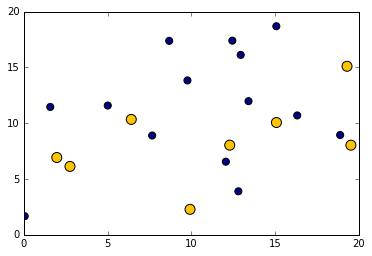

In [242]:
col_dict = {'mono':0,'dimer':7}
size_dict = {'mono':10,'dimer':20}
aa = plt_traj2(t,col_dict, size_dict)
HTML(aa.to_html5_video())
#aa.save('im.mp4')

In [238]:

plt.show()

In [205]:
tr=reshape(t)
pp=tr.groupby(by='ID')
pp.agg({'age':'max', 'type_name':'unique'})

,type_name,age
ID,,
050594a1-a527-4507-88d5-aab7fe19aa5b,[mono],471
09e7fbb9-fc2a-4838-949c-85bf0b64184d,[mono],82
15e8c670-e418-4810-88cd-b7aeceac0075,[mono],799
21184774-ba75-47ff-8ccf-98b5607fbfbe,[mono],1
215286ff-cba0-46d7-94a8-56b7710fd487,[dimer],4917
2457f4b1-74fa-4002-bbf2-d1766be10780,[dimer],4528
27f325b1-ac50-4503-82fc-97820dd6b46a,[dimer],4973
29f59942-453d-4a40-a5fd-65ac6779212e,[mono],5000
2adf8101-c6c4-4ebb-a6c2-cbda142916cf,[mono],2446


In [206]:
lifes = pp.agg({'age':'max', 'type_name':'unique'})
yy = lifes.groupby('type_name')
#for ky, val in yy:
#    print(val)
yy

In [207]:
lifes

,type_name,age
ID,,
050594a1-a527-4507-88d5-aab7fe19aa5b,[mono],471
09e7fbb9-fc2a-4838-949c-85bf0b64184d,[mono],82
15e8c670-e418-4810-88cd-b7aeceac0075,[mono],799
21184774-ba75-47ff-8ccf-98b5607fbfbe,[mono],1
215286ff-cba0-46d7-94a8-56b7710fd487,[dimer],4917
2457f4b1-74fa-4002-bbf2-d1766be10780,[dimer],4528
27f325b1-ac50-4503-82fc-97820dd6b46a,[dimer],4973
29f59942-453d-4a40-a5fd-65ac6779212e,[mono],5000
2adf8101-c6c4-4ebb-a6c2-cbda142916cf,[mono],2446


In [208]:
pp2=tr.groupby(by=['frame','type_name'])
qq2=pp2.agg({'type_name':'count'})

In [17]:
qq2

type_name
frame type_name           
0     type 1            10
      type 2            10
1     type 1            10
      type 2             9
2     type 1            10
      type 2             7
3     type 1            10
      type 2             5
4     type 1            10
      type 2             5
5     type 1            10
      type 2             4
6     type 1             9
      type 1b            1
      type 2             3
7     type 1             9
      type 1b            1
      type 2             3
8     type 1             9
      type 1b            1
      type 2             3
9     type 1             9
      type 1b            1
      type 2             3
10    type 1             8
      type 2             2
11    type 1             8
      type 2             2
12    type 1             8
      type 2             1
...                    ...
86    type 1             2
      type 1b            2
87    type 1             2
      type 1b            2
88    type 1             2
      type 1b            2
89    type 1             2
      type 1b            2
90    type 1             2
      type 1b            2
91    type 1             2
      type 1b            2
92    type 1             1
      type 1b            3
93    type 1             1
      type 1b            3
94    type 1             1
      type 1b            3
95    type 1             1
      type 1b            3
96    type 1             1
      type 1b            3
97    type 1             1
      type 1b            3
98    type 1             1
      type 1b            3
99    type 1             1
      type 1b            3
100   type 1             1
      type 1b            3

[210 rows x 1 columns]

In [ ]:
a.ani.save('im.mp4')